# Notes

* problem statment does not suggest device independence: these could be networked or interdependent systems
* classes are HEAVILY imbalanced; standard concerns on local optima
* [during failure, attributes 2, 4, 7, and 8 report much higher values than normal. This is not true of 1, 3, 5, 6, and 9](#failhard)
* [a1 and a6 are highly unique](#uniqueness)
* [no duplicate data and no missing values](#missing)
* [events appear to be ordered](#ordered)
* [devices appear to come in types/classes](#deviceclasses) 
* [scale or one-hot encoide attributes](#attributevals)
* [a2 & a4 ramp-up before failure, and looks like a7 spikes quickly](#correlation)
* [a3 & a9 are weakly positively correlated](#correlation)
* [a7 & a8 are perfectly positively correlated... because they are identical](#a7a8)
* [a7 appears to be critical in predicting failure in a naive model](#naivemodel)

# Setup

## Imports

In [61]:
# mute warnings
import warnings
warnings.filterwarnings('ignore')

# science
import scipy as sp
import numpy as np
import pandas as pd
import featuretools as ft
import xgboost as xgb
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold

# system
import random
import hashlib
import pickle
import tempfile
import time

# visuals
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from IPython import display

# options
%matplotlib inline
rcParams['figure.figsize'] = 15, 6
sns.set_style('whitegrid')
sns.set_context('notebook')
sns_cmap = sns.diverging_palette(10, 220, sep=80, n=5)
pd.set_option('display.max_colwidth', -1)

# in case nb needs to be re-run
try:
    %load_ext autoreload
except:
    %reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Functions

In [2]:
def load_data(filename):
    '''
    Load a generic CSV file into a pandas dataframe
    '''
    df = pd.read_csv(filename, escapechar='\\', encoding='utf-8')
    df['uuid'] = df.apply(lambda x: hashlib.md5(str(x.values).encode('utf-8')).hexdigest(), axis=1)
    assert sum(df.set_index('uuid').index.duplicated()) == 0, 'Error loading data: Hash collision; duplicate data'
    return df

In [3]:
def calculate_nan_values(orig_df):
    df = orig_df.copy()
    df = df.isna().sum(axis=0).reset_index()
    df.columns = ['column_name', 'na_count']
    df['na_ratio'] = df['na_count'] / orig_df.shape[0]
    df = df.loc[df['na_ratio'] > 0]
    df = df.sort_values(by='na_ratio')
    return df

In [4]:
def calculate_null_values(orig_df):
    df = orig_df.copy()
    df = df.isnull().sum(axis=0).reset_index()
    df.columns = ['column_name', 'null_count']
    df['null_ratio'] = df['null_count'] / orig_df.shape[0]
    df = df.loc[df['null_ratio'] > 0]
    df = df.sort_values(by='null_ratio')
    return df

In [5]:
def value_limits(df, field, upper_bound=99, lower_bound=1):
    upper_limit = np.percentile(df[field].values, upper_bound)
    lower_limit = np.percentile(df[field].values, lower_bound)
    return upper_limit, lower_limit

In [6]:
def visualize_correlations(df, fields):

    # keep a copy
    df = df.copy()

    # correlation coefficient of each column
    for field in fields:
        x_cols = [col for col in df.columns
                  if col != field and (df[col].dtype=='float64' or df[col].dtype=='int64')]
        labels = []
        values = []
        for col in x_cols:
            labels.append(col)
            values.append(
                np.corrcoef(df[col].values, df[field].values)[0, 1])

        # create dataframe for corr coeffs
        corr_df = pd.DataFrame({'col_labels': labels, 'corr_values': values})
        corr_df = corr_df.sort_values(by='corr_values')

        ind = np.arange(len(labels))
        fig, ax = plt.subplots(figsize=(12, 4))
        rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='y')
        ax.set_yticks(ind)
        ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
        ax.set_xlabel('correlation coefficient')
        ax.set_title('Correlations with {}'.format(field))
        ax.set_xlim(-1, 1)
        plt.show()

In [7]:
def visualize_values(df, fields):
    
    # keep a copy
    df = df.copy()

    # iterate over fields
    for field in fields:

        # get limits of data
        ulimit, llimit = value_limits(df, field)
        print('###################')
        print('Working on field {}'.format(field))
        print('Upper limit: {:.3f}'.format(ulimit))
        print('Lower limit: {:.3f}'.format(llimit))

        # plot the ordered values for field
        plt.figure(figsize=(12, 8))
        plt.scatter(range(df.shape[0]), np.sort(df[field].values))
        plt.xlabel('index', fontsize=12)
        plt.ylabel(field, fontsize=12)
        plt.show()

        # plot histo of values
        sns.distplot(df[field].values, bins=50, kde=True, norm_hist=True)
        plt.xlabel(field, fontsize=12)
        plt.show()

In [8]:
def build_model(input_size, output_size):
    x = Input(shape=(input_size,))
    layer1 = Dense(25, activation='relu')(x)
    layer2 = Dense(10)(layer1)
    layer3 = Dense(35)(layer2)
    layer4 = Dense(10)(layer3)
    layer5 = Dense(25, activation=None)(layer4)
    layer6 = Dense(output_size)(layer5)
    model = Model(x, layer6)
    model.compile(optimizer='adam',
                  loss='mean_absolute_error',
                  metrics=['mape'])
    return model

In [9]:
def save_hdf5(df, hdf_file, table_name, format=None):
    if format is not None:
        df.to_hdf(
            hdf_file,
            table_name,
            mode='w',
            format=format,
            data_columns=True,
            complevel=9,
            complib='blosc:lz4')
    else:
        df.to_hdf(
            hdf_file,
            table_name,
            mode='w',
            data_columns=True,
            complevel=9,
            complib='blosc:lz4')

In [10]:
def cohen_kappa_scorer(preds, dmatrix):
    y = dmatrix.get_label()
    cohen_kappa_score(preds, y)
    return 'kappa', score

In [11]:
def train_xgb_model(X_train, y_train, params, kfolds=10, random_seed=7):

    # set a timer
    starttime = timeit.default_timer()

    # setup
    random.seed(random_seed)
    np.random.seed(random_seed)

    # isolate train features
    X_train = X_train.values
    y_train = y_train.astype(int).values
    
    # stratified k-fold
    skf = StratifiedKFold(n_splits=kfolds, random_state=42, shuffle=False)
    for i, (train_index, cv_index) in enumerate(skf.split(X_train, y_train)):
        print('Working on k-fold {}...'.format(i))
        
        # split data
        print('Splitting data')
        X_ktrain, X_kcv = X_train[train_index], X_train[cv_index]
        y_ktrain, y_kcv = y_train[train_index], y_train[cv_index]
        
        # Convert our data into XGBoost format
        print('Converting data to xgb format')        
        d_train = xgb.DMatrix(X_ktrain, label=y_ktrain, feature_names=feature_names)
        d_cv    = xgb.DMatrix(X_kcv, label=y_kcv, feature_names=feature_names)
        watchlist = [(d_train, 'train'), (d_cv, 'cv')]

        # train the model
        print('Modeling')
        model = xgb.train(params, d_train, num_boost_round=3000,
                          evals=watchlist, #feval=cohen_kappa_scorer,
                          early_stopping_rounds=300, verbose_eval=200)
        print('Done.')
    
    # testing
    return model

In [12]:
def sensitivity(y_test, y_pred):
    true_positives = K.sum(K.round(K.clip(y_test * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_test, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

In [13]:
def specificity(y_test, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_test) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_test, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

# Data Ingest

In [14]:
# load data
faults_df = load_data("device_failure.csv")

In [15]:
# see a sample
faults_df.head()

,date,device,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,failure,uuid
0,15001,S1F01085,215630672,56,0,52,6,407438,0,0,7,0,5646eb712abba53b99fd8b8152c8f503
1,15001,S1F0166B,61370680,0,3,0,6,403174,0,0,0,0,4eff5953a2d3610d43197ada2ea8002d
2,15001,S1F01E6Y,173295968,0,0,0,12,237394,0,0,0,0,f9b3e1204591b513e0f1aa53abd65dd9
3,15001,S1F01JE0,79694024,0,0,0,6,410186,0,0,0,0,4c5c11b2f5e33fc3626c669b3ecb45d3
4,15001,S1F01R2B,135970480,0,0,0,15,313173,0,0,3,0,a742b325beb173c3827e77ade95c157d


In [16]:
# rename columns for less typing
faults_df.columns = faults_df.columns.str.replace("attribute", "a")

In [17]:
# odd date format, did load reformat?
!head device_failure.csv

In [18]:
# basic summary for any obvious weirdness
faults_df.describe()

,date,a1,a2,a3,a4,a5,a6,a7,a8,a9,failure
count,124494.000000,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,15106.222798,1.223868e+08,159.484762,9.940455,1.741120,14.222693,260172.858025,0.292528,0.292528,12.451524,0.000851
std,78.412061,7.045960e+07,2179.657730,185.747321,22.908507,15.943021,99151.009852,7.436924,7.436924,191.425623,0.029167
min,15001.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000,0.000000
25%,15040.000000,6.127675e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000,0.000000
50%,15086.000000,1.227957e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000,0.000000
75%,15168.000000,1.833084e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000,0.000000
max,15306.000000,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,18701.000000,1.000000


This data set appears to have attributes that are "codes" and thus categorical. The min/max and stddev for each is large, so there's a spread. One-hot encoding will be... tough.

# QA/QC

## Basics

In [19]:
# per problem statement, one device per day?
check = faults_df.date.astype(str) + faults_df.device.astype(str)
assert len(check) == len(check.drop_duplicates()), 'More than one device per day'

In [20]:
# inspect data types
dtype_df = faults_df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df

,Count,Column Type
0,date,int64
1,device,object
2,a1,int64
3,a2,int64
4,a3,int64
5,a4,int64
6,a5,int64
7,a6,int64
8,a7,int64
9,a8,int64


A1 is very unique: device identifier? <a id="uniqueness"></a>

In [21]:
# inspect uniqueness
uniqueness_df = pd.DataFrame(faults_df.nunique()).reset_index()
uniqueness_df.columns = ["column", "num_unique"]
uniqueness_df['perc_unique'] = uniqueness_df.num_unique.apply(lambda x: x/len(faults_df))
uniqueness_df

,column,num_unique,perc_unique
0,date,304,0.002442
1,device,1168,0.009382
2,a1,123878,0.995052
3,a2,558,0.004482
4,a3,47,0.000378
5,a4,115,0.000924
6,a5,60,0.000482
7,a6,44838,0.360162
8,a7,28,0.000225
9,a8,28,0.000225


Nothing missing <a id="missing"></a>

In [22]:
# nulls
calculate_null_values(faults_df)

,column_name,null_count,null_ratio


In [23]:
# nan's (just to be sure)
calculate_nan_values(faults_df)

,column_name,na_count,na_ratio


In [24]:
# look at columns
for c in sorted(faults_df.columns):
    print(c)

a1
a2
a3
a4
a5
a6
a7
a8
a9
date
device
failure
uuid


Attribute values vary wildly <a id="attributevals"></a>

###################
Working on field date
Upper limit: 15286.000
Lower limit: 15002.000


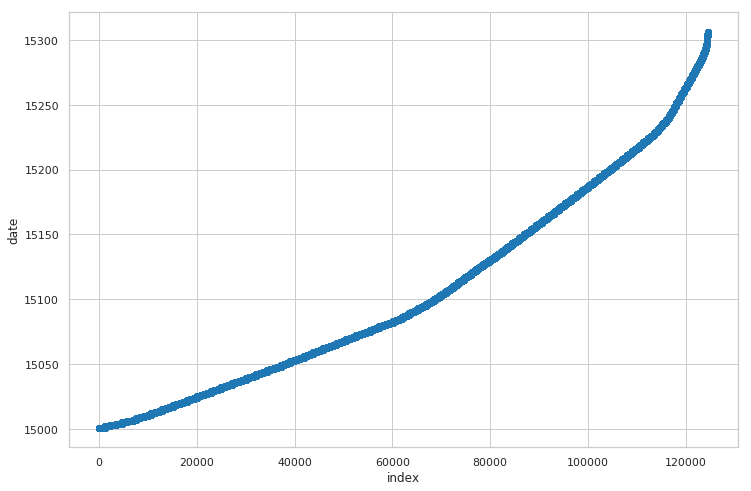

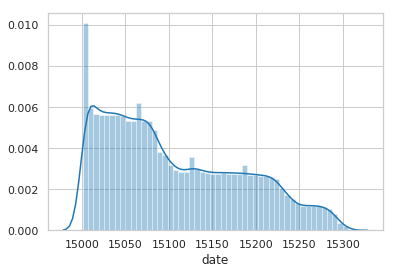

###################
Working on field a1
Upper limit: 241791145.360
Lower limit: 2401025.280


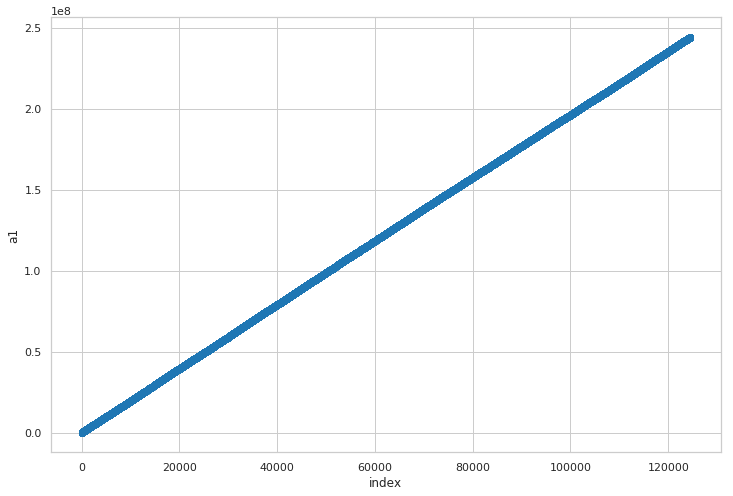

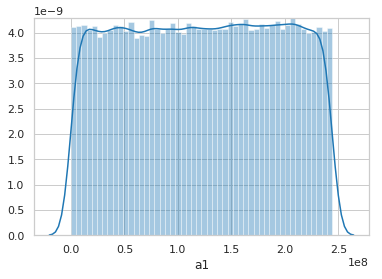

###################
Working on field a2
Upper limit: 2664.000
Lower limit: 0.000


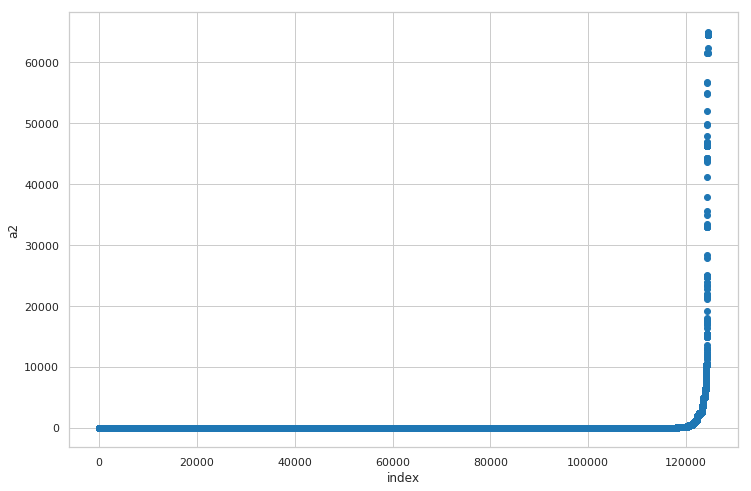

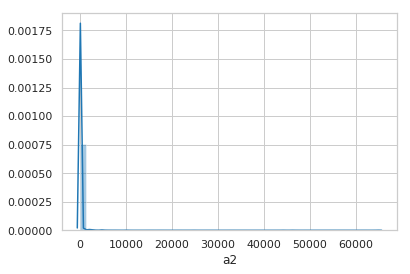

###################
Working on field a3
Upper limit: 107.000
Lower limit: 0.000


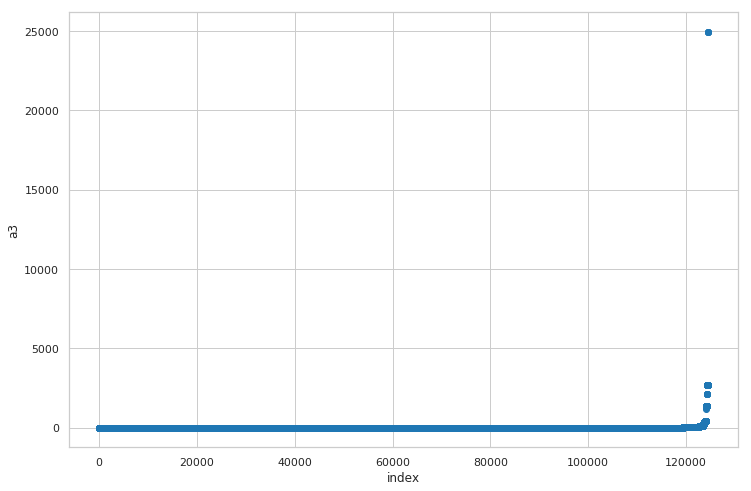

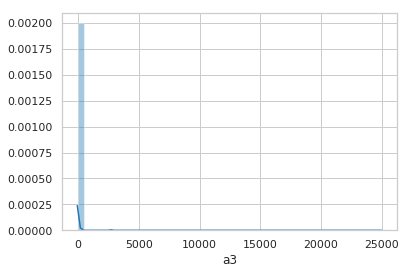

###################
Working on field a4
Upper limit: 25.000
Lower limit: 0.000


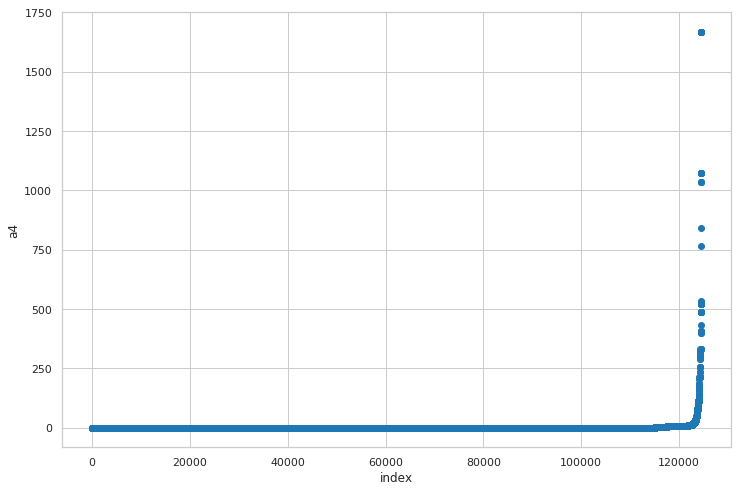

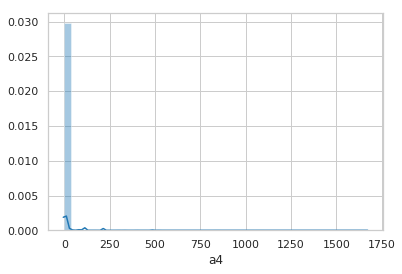

###################
Working on field a5
Upper limit: 92.000
Lower limit: 4.000


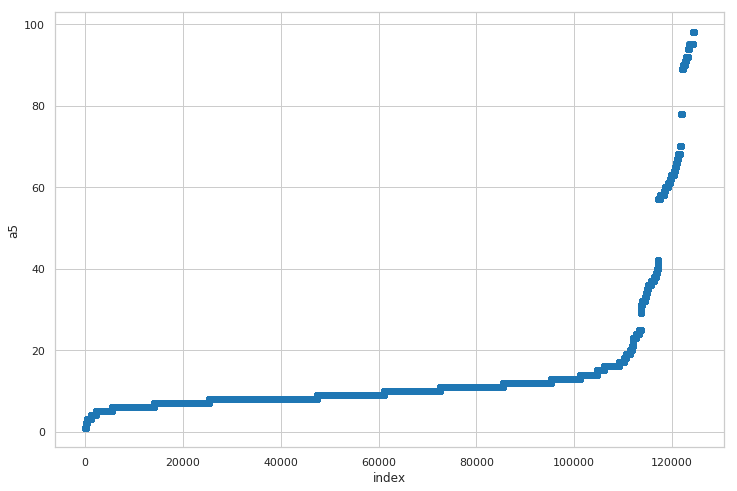

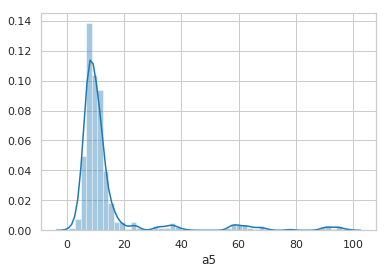

###################
Working on field a6
Upper limit: 501012.490
Lower limit: 26.000


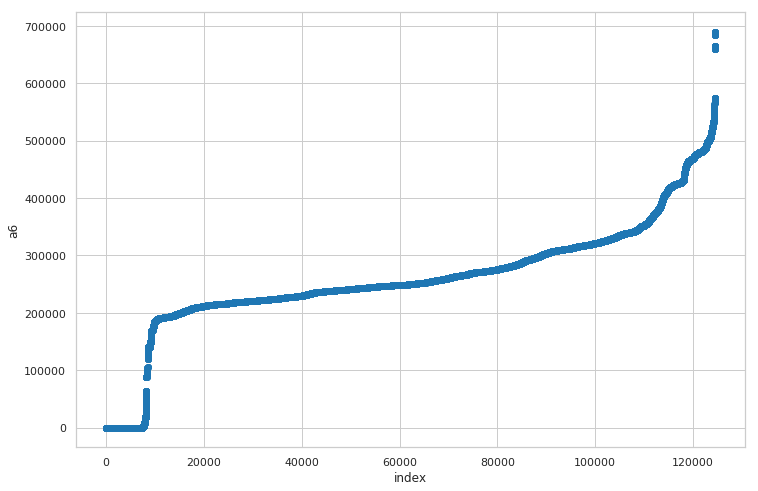

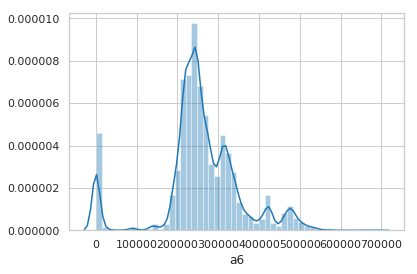

###################
Working on field a7
Upper limit: 8.000
Lower limit: 0.000


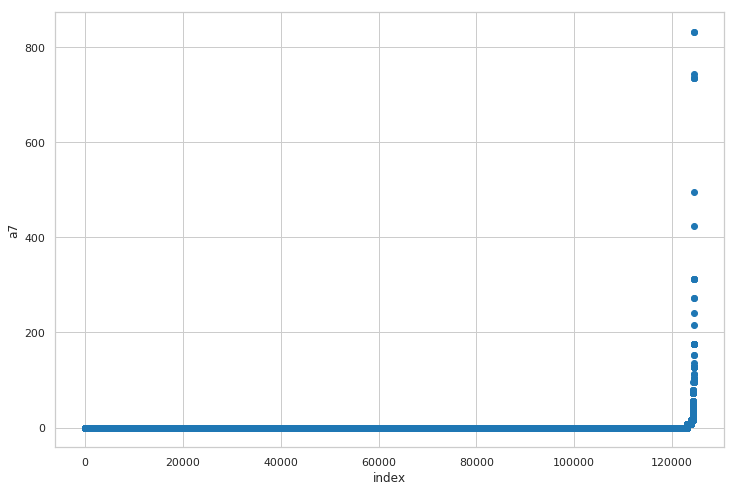

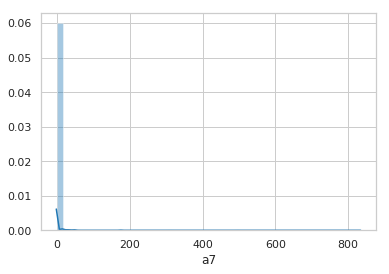

###################
Working on field a8
Upper limit: 8.000
Lower limit: 0.000


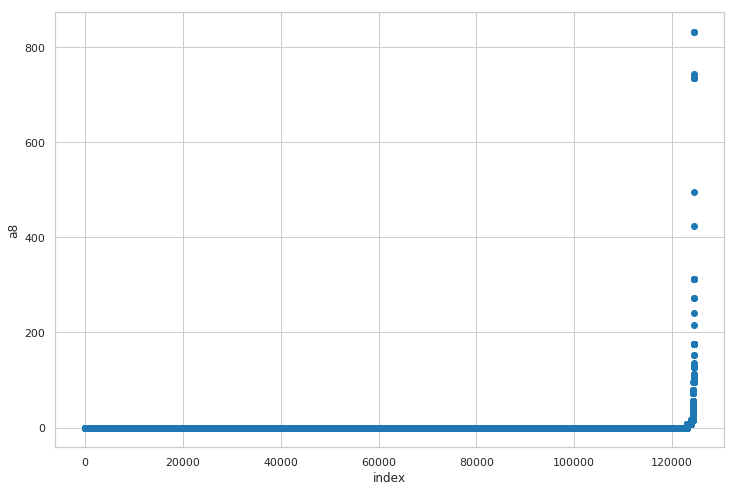

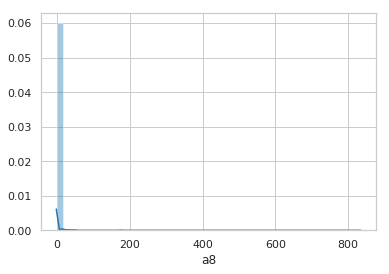

###################
Working on field a9
Upper limit: 155.000
Lower limit: 0.000


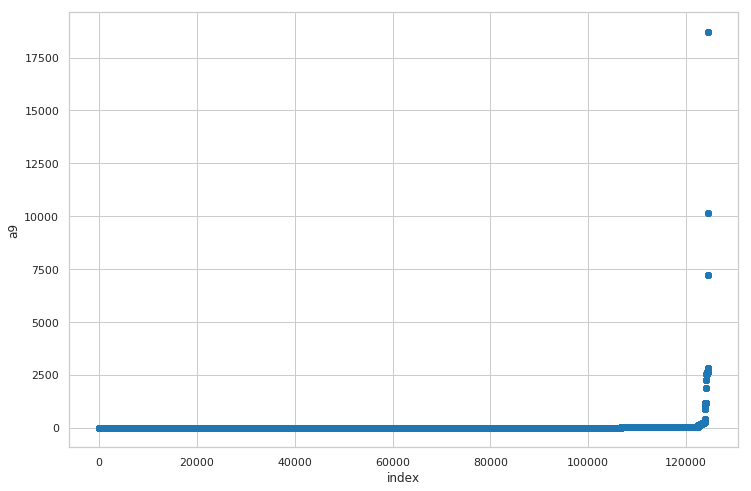

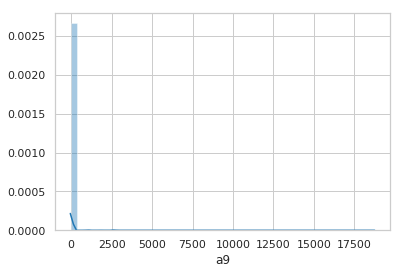

###################
Working on field failure
Upper limit: 0.000
Lower limit: 0.000


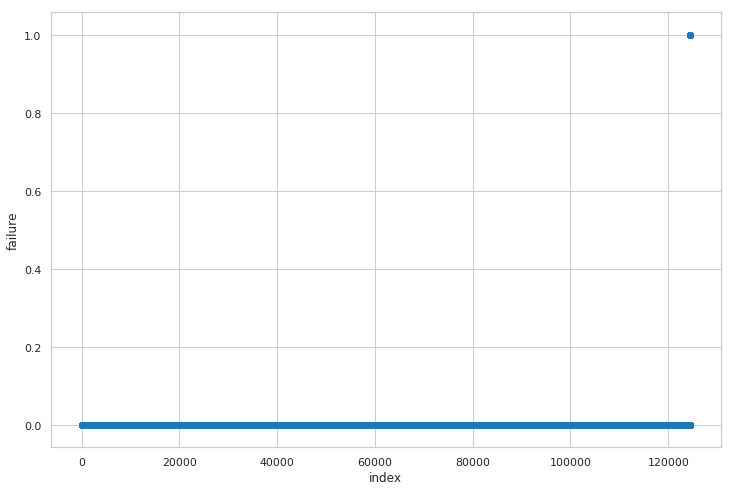

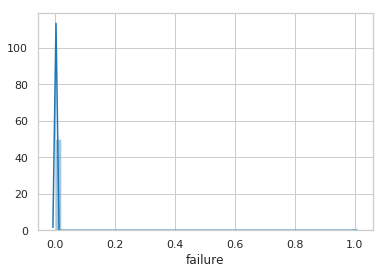

In [25]:
# visualize column values
fields = [c for c in faults_df.columns if faults_df[c].dtype == 'int64']
visualize_values(faults_df, fields)

Some attributes have orders of magnitude higher values than others within same category. Must have units of measure.

In [26]:
cols = faults_df.filter(regex='^a').columns.tolist()
temp = faults_df[cols]

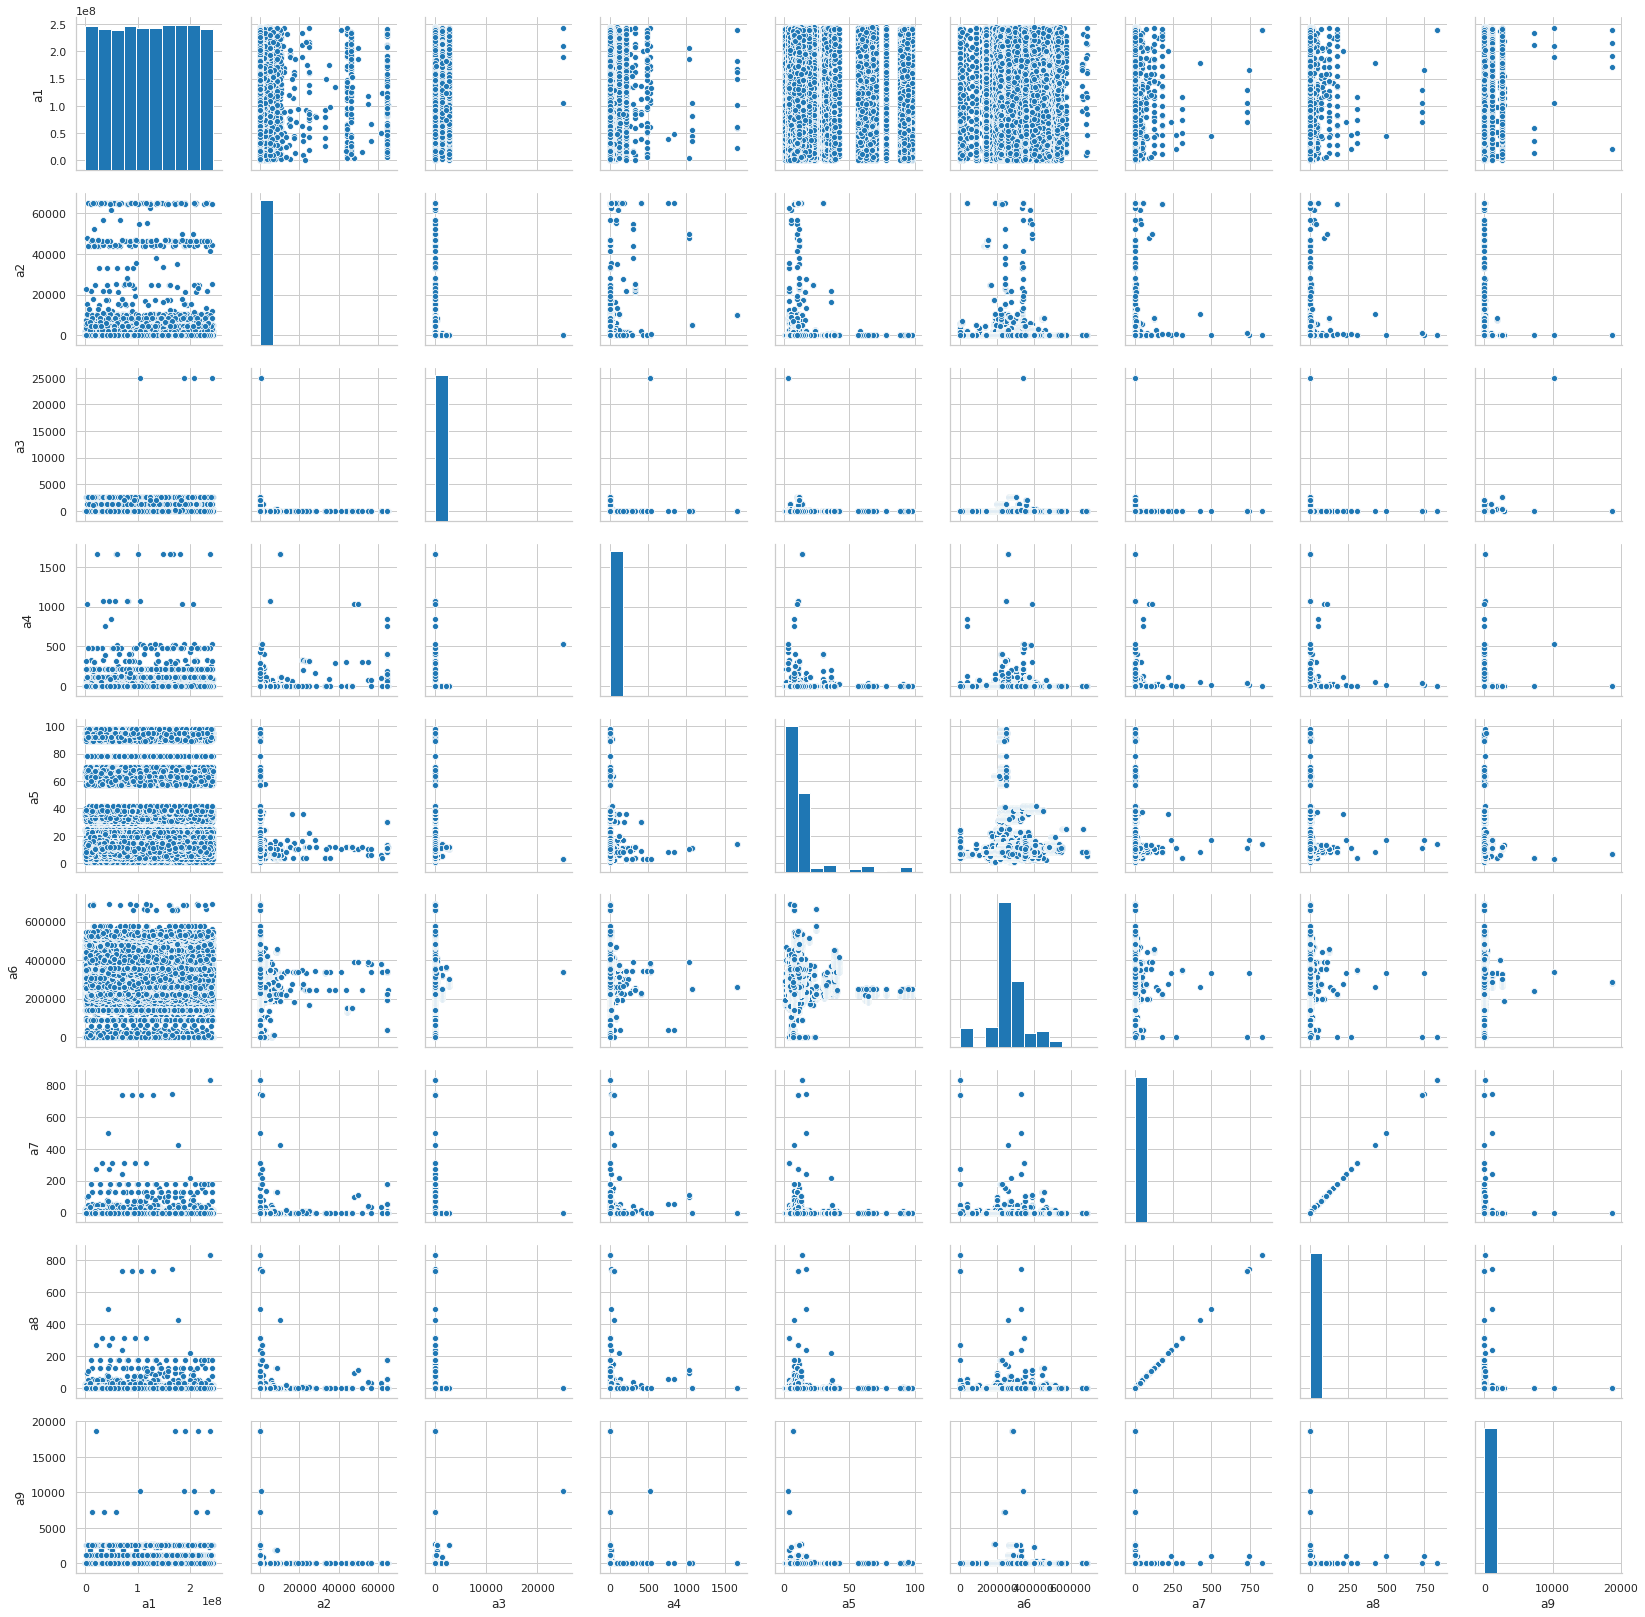

In [27]:
sns.pairplot(temp);

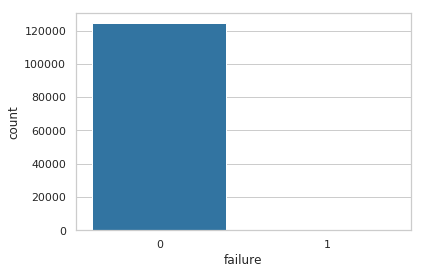

In [28]:
sns.countplot(x="failure", data=faults_df)

Yikes, this is an extreme example of imbalances classes.

In [29]:
100.*faults_df.groupby('failure').failure.count()/len(faults_df)

failure
0    99.914855
1    0.085145 
Name: failure, dtype: float64

"Extreme" is putting it lightly: 99.91% of the time, the data indicates non-failure. **Model #1**: Always predict 'non-failure', you'll be right most of the time :)

In [30]:
temp = faults_df.filter(regex='^a|failure')
scaler = preprocessing.MinMaxScaler()
scaled_values = scaler.fit_transform(temp) 
temp.loc[:,:] = scaled_values
temp_melt = pd.melt(temp, "failure", var_name="measurement")

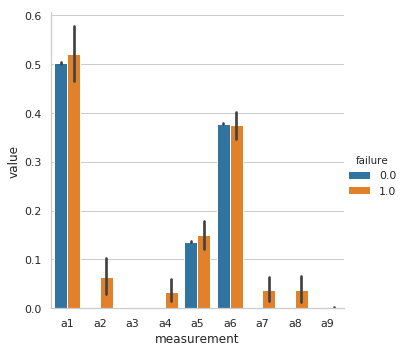

In [32]:
sns.catplot(x="measurement", y="value", hue="failure", kind="bar", data=temp_melt);

Some attributes have values ONLY when a failure occurs: a2, a4, a7, a8?

In [33]:
subtemp = temp.filter(regex='a2|a3|a9|a4|a7|a8|failure')
for c in subtemp.columns:
    subtemp.loc[subtemp[c] > 0, c] = 1

In [34]:
subtemp_melt = pd.melt(subtemp, "failure", var_name="measurement")
grouped = subtemp_melt.groupby(['measurement', 'failure']).sum()

In [35]:
grouped

value
measurement failure         
a2          0.0      6336.0 
            1.0      48.0   
a3          0.0      9124.0 
            1.0      11.0   
a4          0.0      9276.0 
            1.0      62.0   
a7          0.0      1419.0 
            1.0      39.0   
a8          0.0      1419.0 
            1.0      39.0   
a9          0.0      27106.0
            1.0      30.0

Far more values present when not failing, so there must be a slant toward large values when there is a failure?

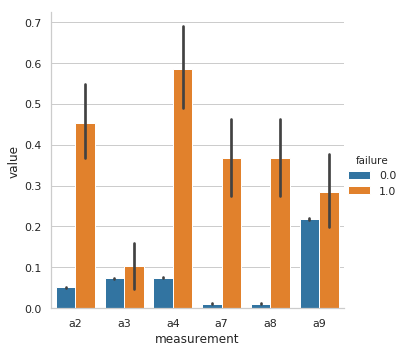

In [36]:
sns.catplot(x="measurement", y="value", hue="failure", kind="bar", data=subtemp_melt);

<a id="failhard"></a>
Looks to be true. When there is a failure, attributes 2, 4, 7, and 8 report much higher values than normal. This is not true of 1, 3, 5, 6, and 9. They should be correlated with failure then...

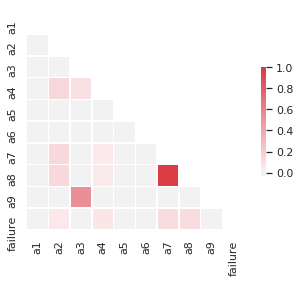

In [37]:
# Draw the heatmap with the mask and correct aspect ratio
corr = temp.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

That is confidence building: a2, a4, a7, and a8 are weakly correlated with failure. Dig on A7==A8 in EDA.

## Date

In [38]:
# what are the dates representing?
dates = faults_df.date
dates.unique()

array([15001, 15002, 15003, 15004, 15005, 15006, 15007, 15008, 15009,
       15010, 15011, 15012, 15013, 15014, 15015, 15016, 15017, 15018,
       15019, 15020, 15021, 15022, 15023, 15024, 15025, 15026, 15027,
       15028, 15029, 15030, 15031, 15032, 15033, 15034, 15035, 15036,
       15037, 15038, 15039, 15040, 15041, 15042, 15043, 15044, 15045,
       15046, 15047, 15048, 15049, 15050, 15051, 15052, 15053, 15054,
       15055, 15056, 15057, 15058, 15059, 15060, 15061, 15062, 15063,
       15064, 15065, 15066, 15067, 15068, 15069, 15070, 15071, 15072,
       15073, 15074, 15075, 15076, 15077, 15078, 15079, 15080, 15081,
       15082, 15083, 15084, 15085, 15086, 15087, 15088, 15089, 15090,
       15091, 15092, 15093, 15094, 15095, 15096, 15097, 15098, 15099,
       15100, 15101, 15102, 15103, 15104, 15105, 15106, 15107, 15108,
       15109, 15110, 15111, 15112, 15113, 15114, 15115, 15116, 15117,
       15118, 15119, 15120, 15121, 15122, 15123, 15124, 15125, 15126,
       15127, 15128,

Dates look ordered <a id="ordered"></a>

In [39]:
# is it sorted?
all(dates[i] <= dates[i+1] for i in range(len(dates)-1))

True

In [40]:
# so these are ordered, arbitrarily assigned dates representations
pd.Series(dates.unique()).diff().unique()

array([nan,  1.,  2.])

 Can't create datetime augmentations; Day of week, time of month, et al. may be important, cannot hardcode unknown information.

In [41]:
# add order val in case its useful
faults_df.insert(0, 'order', range(0, len(faults_df)))

As long as a date transformation is applied uniformly such that relative information is preserved, creating a datetime object with an arbitrary reference is okay.

In [42]:
faults_df['datetime'] = faults_df['date'].apply(lambda x: pd.to_datetime(x, unit='d'))

## Device

In [43]:
# isolate devices
devices = faults_df.device
devices.unique()

array(['S1F01085', 'S1F0166B', 'S1F01E6Y', ..., 'S1F02W1L', 'S1F02XLX',
       'S1F03499'], dtype=object)

In [44]:
# num of devices
len(devices.unique())

1168

In [45]:
# how many chars in each field of device name?
maxchars = max(devices.apply(lambda x: len(x)))
for nchar in range(0, maxchars):
    print('Char position {} :: num unique {}'.format(nchar,
                                                     len(devices.apply(lambda x: x[nchar]).unique())))

Char position 0 :: num unique 3
Char position 1 :: num unique 1
Char position 2 :: num unique 1
Char position 3 :: num unique 3
Char position 4 :: num unique 33
Char position 5 :: num unique 33
Char position 6 :: num unique 33
Char position 7 :: num unique 33


In [46]:
# first four chars don't vary much
# are there flavors of naming conventions, e.g. device classes?
maxchars = max(devices.apply(lambda x: len(x)))
for nchars in range(0, maxchars):
    print('num chars {} :: num unique {}'.format(nchars,
                                              len(devices.apply(lambda x: x[:nchars]).unique())))

num chars 0 :: num unique 1
num chars 1 :: num unique 3
num chars 2 :: num unique 3
num chars 3 :: num unique 3
num chars 4 :: num unique 7
num chars 5 :: num unique 121
num chars 6 :: num unique 608
num chars 7 :: num unique 1104


I'm getting suspicious that there is time ordering which could be informative: a device failure tree. So want to keep that ordering going forward -- no groupby's! Cross device failures may be important. <a id="deviceclasses"></a>

In [47]:
# save the class1
faults_df['device_class1'] = faults_df.device.apply(lambda x: x[:3])

In [48]:
faults_df.device_class1.unique()

array(['S1F', 'W1F', 'Z1F'], dtype=object)

In [49]:
# remove class1 and look for more
sub_devices = devices.apply(lambda x: x[3:])
maxchars = max(sub_devices.apply(lambda x: len(x)))
for nchars in range(1, maxchars):
    print('num chars {} :: num unique {}'.format(nchars,
                                              len(sub_devices.apply(lambda x: x[:nchars]).unique())))

num chars 1 :: num unique 3
num chars 2 :: num unique 59
num chars 3 :: num unique 550
num chars 4 :: num unique 1101


In [50]:
# maybe 4th char is a status? small enough to encode
faults_df['device_class2'] = faults_df.device.apply(lambda x: x[3])

In [51]:
faults_df.device_class2.unique()

array(['0', '1', '2'], dtype=object)

In [52]:
# remove class1 and class2 and look for more
sub_devices = devices.apply(lambda x: x[4:])
maxchars = max(sub_devices.apply(lambda x: len(x)))
for nchars in range(1, maxchars):
    print('num chars {} :: num unique {}'.format(nchars,
                                              len(sub_devices.apply(lambda x: x[:nchars]).unique())))

num chars 1 :: num unique 33
num chars 2 :: num unique 514
num chars 3 :: num unique 1094


In [53]:
# lump remainder together
faults_df['device_class3'] = faults_df.device.apply(lambda x: x[4:])

In [54]:
faults_df.device_class3.unique()

array(['1085', '166B', '1E6Y', ..., '2W1L', '2XLX', '3499'], dtype=object)

In [55]:
# check that original device == device clases
sum(faults_df.device != faults_df.device_class1 + faults_df.device_class2 + faults_df.device_class3)

0

## Save

In [56]:
faults_df.to_pickle('faults_df.pkl')

# EDA

In [ ]:
while True:
    try:
        # pick random device that had a failure and look at attribute trends in time
        temp = faults_df[(faults_df.failure == 1)]
        rand_device = temp.sample(1).device.values[0]
        temp = faults_df[(faults_df.device == rand_device)]
        temp = temp.filter(regex='^a|date$')
        temp['a1cs'] = temp.a1.cumsum()
        scaler = preprocessing.MinMaxScaler()
        scaled_values = scaler.fit_transform(temp)
        temp.loc[:,:] = scaled_values
        temp.plot(x='date', style='.-')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(1)
    except KeyboardInterrupt:
        break

a1 looks like a daily value, a6 is an aggregate. a2 and a4 clearly stand-out as ramping up before failure, but is that common regardless? A few attributes are correlated it appears. <a id="correlation"></a>

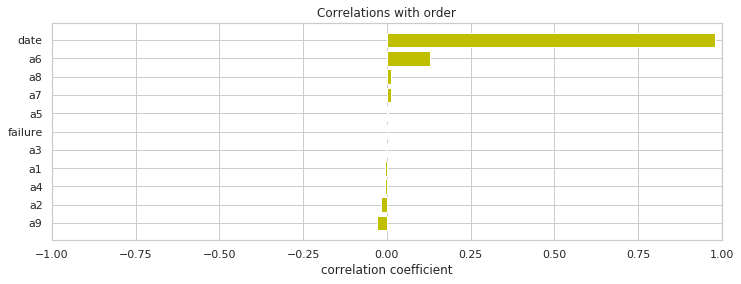

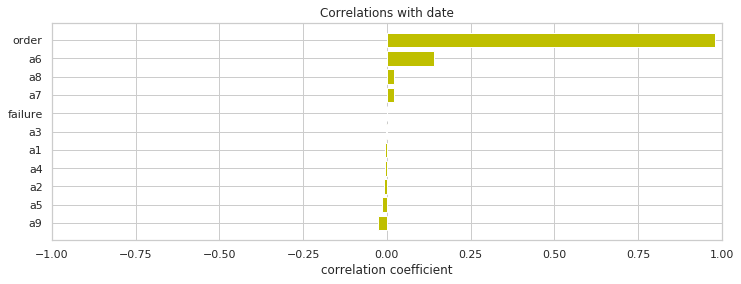

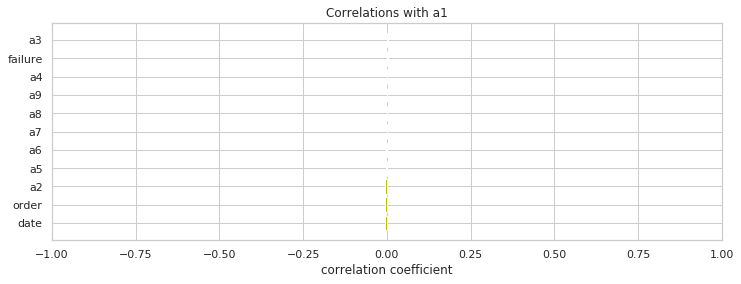

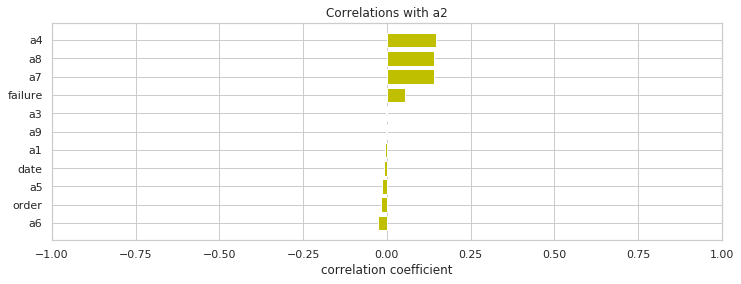

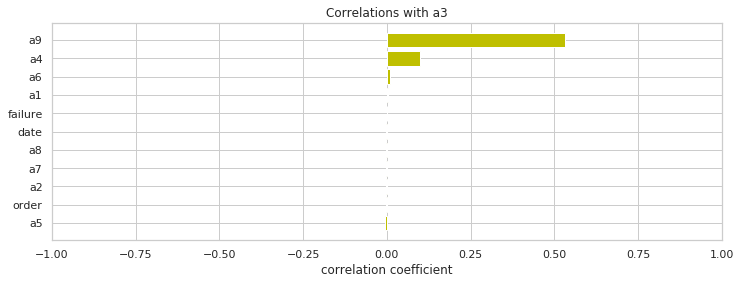

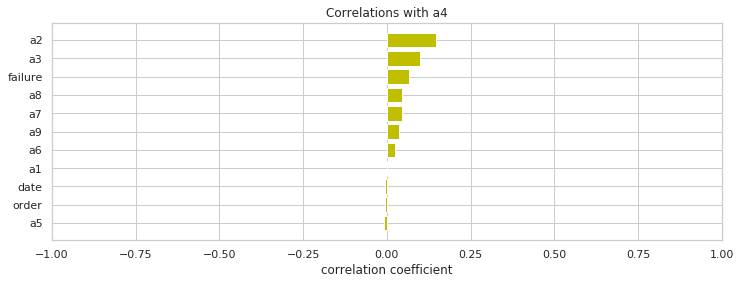

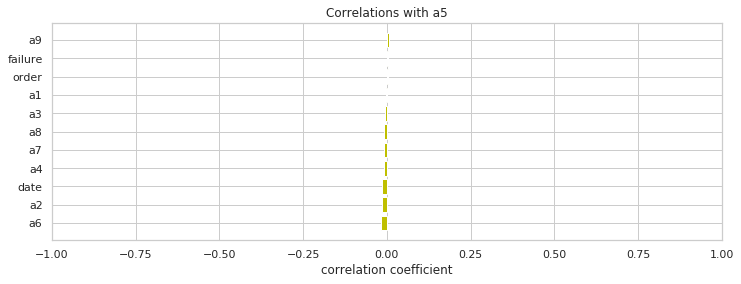

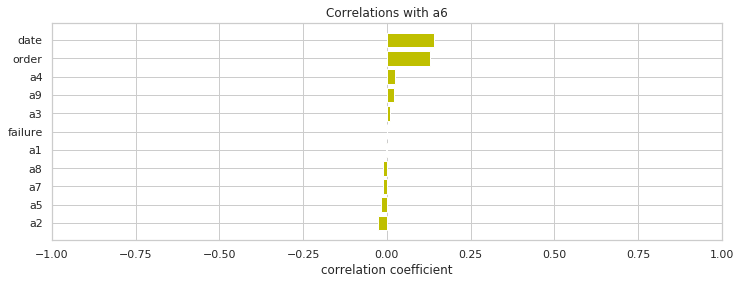

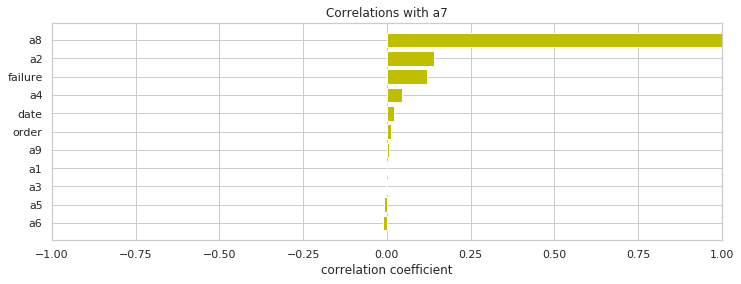

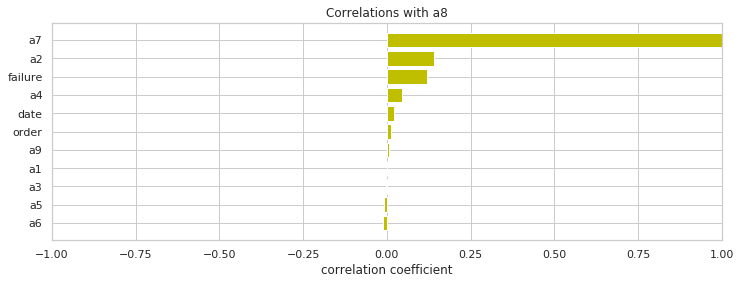

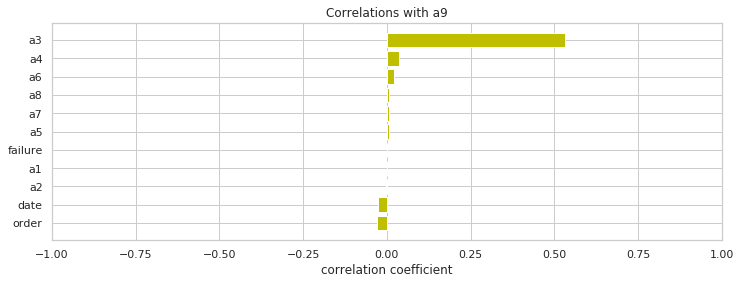

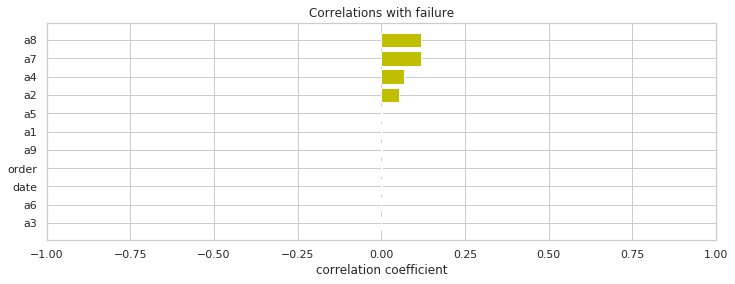

In [63]:
# look for correlations in numerical values
fields = [c for c in faults_df.columns if faults_df[c].dtype == 'int64']
visualize_correlations(faults_df, fields)

A7 and A8 identical? <a id="a7a8"></a>

In [64]:
# are attribute 7 and 8 identical?
a7_str = ''.join(faults_df.a7.astype(str).values)
a7_hash = hashlib.md5(a7_str.encode('utf-8')).hexdigest()

a8_str = ''.join(faults_df.a8.astype(str).values)
a8_hash = hashlib.md5(a8_str.encode('utf-8')).hexdigest()

a7_hash == a8_hash

True

This is telemetry data, so maybe A7 and A8 are the same measurement, different units, e.g. imperial and metric

In [65]:
# 7 was my fav num as a kid (Boomer Esiason wore it for the Bengals)
# drop attr8
faults_df.drop('a8', inplace=True, axis=1)

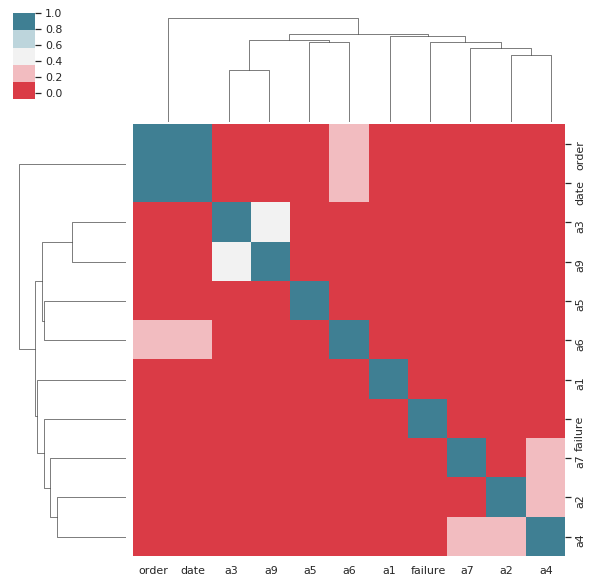

In [66]:
# correlation matrix
corrmat = faults_df.corr(method='spearman')

# Draw the heatmap using seaborn
sns.clustermap(corrmat, vmax=1., square=True, cmap=sns_cmap)

Weak similarities, but nothing so glaring we should break attributes apart.

# Feature Engineering

This is a gnarly imbalanced class problem. Traditional options:
* undersample: this is time series data, so arbitrarily throwing out samples removes valuable information.
* oversample: I dislike the idea of duplicate data since it assumes events are reproducible.
* synthesis: I intensely dislike creating data unless there are strong underlying laws/principles, e.g. in physics, which constrain the fake data.
* stratified resampling: this is a modeling technique we'll have to use.

Normally, we would put in a great deal of effort and time with SME's to build features. For example, cumulative sums of aggregated values over time should be important, and we can engineer such a set of features with:
```python
for col in ['a'+str(i) for i in range(1,10)]:
    newcol = col+'_cumsum'
    try:
        faults_df.drop([newcol], axis=1, inplace=True)
    except:
        pass
    try:
        faults_df[newcol] = faults_df.groupby(['device'])[col].cumsum()
    except:
        continue
```

However, what about all the other stats terms that may have embeded info (count, max, min, mean, stddev, etc.). This is laborious to construct all those features. Alternatively, we could use a carefully tuned NN architecture to find those features via the model. This is also laborious. Another option: create an ensemble of models that extract predictive information from features it creates.

As a start, let's instead try deep feature synthesis and drive the problem to the left (data) rather than to the right (model). This can be accomplished with time series using [tensor deep feature synthesis][tdfs].

[tdfs]: https://docs.featuretools.com/automated_feature_engineering/handling_time.html#creating-a-3-dimensional-feature-tensor-using-multiple-cutoff-times-from-make-temporal-cutoffs

## Cut-off Times

In [67]:
# list of unique devices
unique_devices = faults_df.filter(regex='device').drop_duplicates()
instance_ids = sorted(unique_devices.device.tolist())

# capture start dates per device -- ORDER MATTERS
device_start_dates = faults_df.sort_values(by=['device']).groupby('device')['datetime'].min().tolist()

# capture end dates per device -- ORDER MATTERS
device_end_dates = faults_df.sort_values(by=['device']).groupby('device')['datetime'].max().tolist()

# create reference data frame
cutoffs = pd.DataFrame(
    {
        'instance_ids': instance_ids,
        'start': device_start_dates,
        'cutoffs': device_end_dates,
    }
)

In [68]:
# gut check on 100 random entries that reassembly of dates and devices match
for n in range(0, 100):
    
    # pick random device
    rand_device = faults_df.sample(1).device.values[0]
    
    # get original min/max dates in np datetime
    min_test = faults_df[(faults_df.device == rand_device)]['datetime'].min().to_datetime64()
    max_test = faults_df[(faults_df.device == rand_device)]['datetime'].max().to_datetime64()
    
    # get cutoff values
    rand_min = cutoffs[(cutoffs.instance_ids == rand_device)].start.values[0]
    rand_max = cutoffs[(cutoffs.instance_ids == rand_device)].cutoffs.values[0]
    
    # compare
    assert rand_min == min_test, 'Date mismatch'
    assert rand_max == max_test, 'Date mismatch'

In [69]:
# for each device, begin at start and increment by 1-day until the end
temporal_cutoffs = ft.make_temporal_cutoffs(
    instance_ids=cutoffs['instance_ids'],
    start=cutoffs['start'],
    cutoffs=cutoffs['cutoffs'],
    window_size='1d')

In [70]:
# save
temporal_cutoffs.to_pickle('temporal_cutoffs.pkl')

## Deep Feature Synthesis

In [94]:
# Create new entityset
es = ft.EntitySet(id='device_faults')

In [95]:
# create entity for devices
es = es.entity_from_dataframe(
    entity_id='unique_devices',
    dataframe=unique_devices,
    index='device')

In [96]:
# check
es['unique_devices']

Entity: unique_devices
  Variables:
    device (dtype: index)
    device_class1 (dtype: categorical)
    device_class2 (dtype: categorical)
    device_class3 (dtype: categorical)
  Shape:
    (Rows: 1168, Columns: 4)

In [97]:
# create entity for faults
es = es.entity_from_dataframe(
    entity_id='faults',
    dataframe=faults_df,
    index='uuid',
    time_index='datetime')

In [98]:
# check
es['faults']

Entity: faults
  Variables:
    uuid (dtype: index)
    order (dtype: numeric)
    date (dtype: numeric)
    device (dtype: categorical)
    a1 (dtype: numeric)
    a2 (dtype: numeric)
    a3 (dtype: numeric)
    a4 (dtype: numeric)
    a5 (dtype: numeric)
    a6 (dtype: numeric)
    a7 (dtype: numeric)
    a9 (dtype: numeric)
    failure (dtype: numeric)
    datetime (dtype: datetime_time_index)
    device_class1 (dtype: categorical)
    device_class2 (dtype: categorical)
    device_class3 (dtype: categorical)
  Shape:
    (Rows: 124494, Columns: 17)

In [99]:
# Relationship between clients and previous loans
relation_device_faults = ft.Relationship(es['unique_devices']['device'],
                                         es['faults']['device'])

# Add the relationship to the entity set
es = es.add_relationship(relation_device_faults)

In [100]:
# check
es

Entityset: device_faults
  Entities:
    unique_devices [Rows: 1168, Columns: 4]
    faults [Rows: 124494, Columns: 17]
  Relationships:
    faults.device -> unique_devices.device

In [ ]:
# save results
es.to_parquet('device_faults_entity_set')

In [ ]:
# reload data
es = ft.read_parquet('device_faults_entity_set')
temporal_cutoffs = pd.read_pickle('temporal_cutoffs.pkl')

The below step can be parallelized using Dask (`n_jobs=-1`) since it's an embarassingly parallel problem due to independence:

$device_i \perp cutoff_j \perp feature matrix_j$

In [101]:
# reminder of the dfs primitives
ft.primitives.list_primitives()

,name,type,description
0,n_most_common,aggregation,Finds the N most common elements in a categorical feature.
1,num_true,aggregation,Finds the number of 'True' values in a boolean.
2,any,aggregation,Test if any value is 'True'.
3,num_unique,aggregation,Returns the number of unique categorical variables.
4,last,aggregation,Returns the last value.
5,min,aggregation,Finds the minimum non-null value of a numeric feature.
6,sum,aggregation,Counts the number of elements of a numeric or boolean feature.
7,max,aggregation,Finds the maximum non-null value of a numeric feature.
8,std,aggregation,Finds the standard deviation of a numeric feature ignoring null values.
9,count,aggregation,Counts the number of non null values.


In [102]:
# primitive selections
agg_primitives=["mean", "median", "mode", "max", "min", "std", "skew",
                "all", "sum", "count", "num_unique", "trend",
                "last", "time_since_last", "avg_time_between"]

trans_primitives=["cum_count", "cum_sum", "cum_mean", "cum_max",
                  "time_since_previous",
                  "mod", "add", "subtract", "diff", "divide"]

In [108]:
ignore_variables = {'faults': ['uuid',
                               'date',
                               'device_class1',
                               'device_class2',
                               'device_class3',
                               'failure']
                   }

In [ ]:
# create the feature tensor
feature_tensor, feature_defs = ft.dfs(
    entityset=es,
    target_entity='unique_devices',
    cutoff_time=temporal_cutoffs,
    cutoff_time_in_index=True,
    agg_primitives=agg_primitives,
    trans_primitives=trans_primitives,
    ignore_variables=ignore_variables,
    max_depth=2,
    max_features=-1,
    n_jobs=-1,
    verbose=True)

In [ ]:
# save intermediate output
hdf_file = 'raw_dfs_feature_tensor.h5'
table_name = 'feature_tensor'
save_hdf5(feature_tensor, hdf_file, table_name)

## DFS QA

In [ ]:
# clean-up data and don't disturb original
dfs_qa = feature_tensor.copy().reset_index()
dfs_qa.rename(columns={'time':'datetime'}, inplace=True)

In [ ]:
# data in == data out
orig_len = len(dfs_qa)
new_len = len(feature_tensor)
assert orig_len == new_len, 'There is new or missing data'

The '1d' time windows in DFS automatically create steps in time where there may not be data, e.g.:
* original: [1 2 3 4 8 9]
* dfs: [1 2 3 4 **_5 6 7_** 8 9]

There are added values. Simply joing back against original dataframe (need to do anyways) fixes this.

In [ ]:
# per problem statement, one device per day?
check = dfs_qa.datetime.astype(str) + dfs_qa.device.astype(str)
assert len(check) == len(check.drop_duplicates()), 'More than one device per day'

In [ ]:
# rid ourselves of the junk datetime features due to arbitrary date assignment
dropcols = dfs_qa.filter(regex='DAY|MONTH|WEEKDAY|YEAR').columns.tolist()
nunique = dfs_qa.apply(pd.Series.nunique)
dropcols.extend(nunique[nunique == 1].index.tolist())
list(set(dropcols))

In [ ]:
# drop them
dfs_qa.drop(dropcols, axis=1, inplace=True)

In [ ]:
# merge dfs with original faults
faults_dfs_df = pd.merge(faults_df, dfs_qa, on=['device','datetime'], suffixes=('', '_y'))
assert len(faults_dfs_df) == len(faults_df), 'Something went wrong in merge'

In [ ]:
# some duplicate columns in join
dropcols = faults_dfs_df.filter(regex='_y')
faults_dfs_df.drop(dropcols, axis=1, inplace=True)

In [ ]:
# 10 min runtime for above on laptop, save output just in case
hdf_file = 'qa_dfs_feature_tensor.h5'
table_name = 'feature_tensor'
save_hdf5(faults_dfs_df, hdf_file, table_name, format='table')

# Training Data

In [ ]:
# reload data
hdf_file = 'qa_dfs_feature_tensor.h5'
table_name = 'feature_tensor'
Xy = pd.read_hdf(hdf_file, table_name)
feature_names = Xy.columns.tolist()

In [ ]:
# some dfs are uniform
nunique = Xy.apply(pd.Series.nunique)
dropcols = nunique[nunique == 1].index.tolist()
sorted(dropcols)

In [ ]:
# remove uniform cols
if len(dropcols) > 0:
    Xy.drop(dropcols, axis=1, inplace=True)

In [ ]:
Xy.head()

In [ ]:
feature_names

In [ ]:
# columns to encode
encode_cols = [
    'device_class1',
    'device_class2',
    'device_class3'
]

In [ ]:
# one-hot encode the categoricals
Xy = pd.concat([Xy, pd.get_dummies(Xy[encode_cols])], axis=1)
Xy.drop(encode_cols, axis=1, inplace=True)

In [ ]:
# junk features
dropcols = Xy.filter(regex='MODE\(faults.device_class')
Xy.drop(dropcols, axis=1, inplace=True)

In [ ]:
# save intermediate output
hdf_file = 'model_dfs_feature_tensor.h5'
table_name = 'feature_tensor'
save_hdf5(Xy, hdf_file, table_name)

# Modeling

## Data Prep

In [ ]:
# reload data from prior run as a quick start
faults_df = load_data("device_failure.csv")
hdf_file = 'model_dfs_feature_tensor.h5'
table_name = 'feature_tensor'
Xy = pd.read_hdf(hdf_file, table_name)

In [ ]:
# ID cols to use in modeling
ignore = ['date', 'device', 'datetime']
ignore.extend(Xy.filter(regex='failure').columns)  # anything with failure info
predicting = 'failure'
predictors = [c for c in Xy.columns if (c != predicting and c not in ignore)]

# isolate y from X
y = Xy[predicting]
X = Xy[predictors]

# split data into train and test sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, random_state=7)

# remove uuid and track as index
idx_train = X_train.uuid.values
idx_test = X_test.uuid.values
X_train.drop('uuid', axis=1, inplace=True)
X_test.drop('uuid', axis=1, inplace=True)
feature_names = X_train.columns.values
assert set(feature_names) == set(X_test.columns.values), 'Train/Test feature name mismatch'

## xgboost

In [ ]:
# make the train test vers for xgb
dtrain = xgb.DMatrix(X_train, y_train, feature_names=feature_names, nthread=-1)
dtest = xgb.DMatrix(X_test, y_test, feature_names=feature_names, nthread=-1)

### Naive Model

In [ ]:
# define a naive model
xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'max_bin': 1024,
    'max_leaves': 255,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'num_boost_round': 500,
    'objective': 'binary:logistic',
    'silent': 1,
    'seed': 0,
    'tree_method': 'gpu_hist',
    'grow_policy': 'depthwise',
    'n_gpus': 1
}
model = xgb.train(xgb_params, dtrain)

<a id="#naivemodel"></a>
Is a7 really that important?

In [ ]:
# plot the important features #
fig, ax = plt.subplots(figsize=(10, 18))
xgb.plot_importance(model, height=0.6, ax=ax, max_num_features=10)
fig.savefig('feature_importance.png', bbox_inches='tight', pad_inches=1)
plt.show()

In [ ]:
# prediction on test set
y_pred = model.predict(dtest)

In [ ]:
plot_confusion(y_test, y_pred)

In [ ]:
# let's see if this makes sense
temp = faults_df.filter(regex='^a|failure')
scaler = preprocessing.MinMaxScaler()
scaled_values = scaler.fit_transform(temp)
temp.loc[:,:] = scaled_values
temp_melt = pd.melt(temp, "failure", var_name="measurement")
temp_melt.groupby(['measurement', 'failure']).std()

stddev for a4 and a7 are an order of magnitude larger when there's a failure.

In [ ]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

### Tuned Model

In [ ]:
# control for class imbalance
ratio = float(np.sum(y == 0)) / np.sum(y == 1)

# model params
params = {
    'max_depth': 9,
    'min_child_weight': 100,
    'subsample': 0.9,  # random sample %
    'colsample_bytree': 0.4,  # random col %
    'eta': 0.01,  # learning rate
    'reg_alpha': 0.5,  # L1 reg
    'lambda': 0.95,  # L2 reg
    'gamma': 0.1,  # loss split
    'seed': 6,
    'n_estimators': 1000,
    'scale_pos_weight': ratio,  # VERY IMPORTANT FOR THIS PARTICULAR PROBLEM
    'objective': 'gpu:binary:logistic',
    #'objective': 'multi:softprob',
    #'num_class': 2,
    'eval_metric': 'auc',
    'tree_method': 'gpu_hist',
    'grow_policy': 'depthwise'
}

# train the model
model = train_xgb_model(X_train, y_train, params, kfolds=10)

In [ ]:
# feature importance plot
fig, ax = plt.subplots(figsize=(10, 18))
xgb.plot_importance(model, height=0.6, ax=ax, max_num_features=10)
fig.savefig('feature_importance.png', bbox_inches='tight', pad_inches=1)

In [ ]:
# predict
y_pred = model.predict(dtest, ntree_limit=model.best_ntree_limit)

In [ ]:
# binary predictions
target_names = ['no fail', 'fail']
for prob_thresh in np.arange(0.4950, 0.4951, 0.00001):
    y_pred_binary = [1 if x > prob_thresh else 0 for x in y_pred ]
    print(prob_thresh)
    print(metrics.classification_report(y_test, y_pred_binary, target_names=target_names))

In [ ]:
# select threshold
y_pred_binary = [1 if x >= 0.49502 else 0 for x in y_pred ]

In [ ]:
# visualize prec-recall
average_precision = metrics.average_precision_score(y_test, y_pred)
precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred)
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Binary Precision-Recall: Avg Precision={0:0.2f}'.format(average_precision))

In [ ]:
# cm
ax = sns.heatmap(metrics.confusion_matrix(y_test, y_pred_binary), annot=True, annot_kws={"size": 16});
ax.set(title='Confusion Matrix', xlabel='Predicted', ylabel='Actual');

In [ ]:
# roc
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## AutoML

In [ ]:
import h2o
from h2o.automl import H2OAutoML

In [ ]:
h2o.init()
h2o.cluster().show_status()

In [ ]:
train_df_h2o = h2o.H2OFrame(Xy)

In [ ]:
train, test, valid = train_df_h2o.split_frame(ratios=[0.7, 0.15])

In [ ]:
# Identify predictors and response
x = train[predictors].columns
y = predicting

In [ ]:
# Run AutoML
aml = H2OAutoML(max_runtime_secs=3600, balance_classes=True)
aml.train(x=x,
          y=y,
          training_frame=train,
          validation_frame=valid,
          leaderboard_frame=test)#,
          #class_sampling_factors=
          #max_after_balance_size=)

In [ ]:
# View the AutoML Leaderboard
lb = aml.leaderboard

In [ ]:
lb

In [ ]:
# The leader model is stored here
aml.leader

AutoML "likes" SKEW(a4) like xgboost did.

In [ ]:
# predictions
y_pred = aml.leader.predict(test)

## FFNN

Just kidding. There is too little information on the data set to justify building a network of arbitrary architecture. For example, if devices are connected or if device_class<n> is one part of a single entity, then this impacts the model architecture.

In [ ]:
class_weight={
    1: n_non_cancer_samples / n_cancer_samples * t
}

In [ ]:
model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(0.001),
    metrics=[sensitivity, specificity]
)

# Scratch